In [93]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Statistical Tests
import scipy.stats as stats

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

import wrangle_zillow as wrangle
import model

# Executive Summary:
    ## - Project Goal : To find drivers of logerror in the Zillow Database for 2017 Single Unit Properties
    ## - Key Findings : 
        -Clustering to find possible blindspots in feature engineering did not prove useful
        -Linear Regression Model (Tweedie Regressor Model) performed 1.04% better than the baseline when using select features
        -Based on the features used for the best performing model, Bath_bed_ratio, Total Square Feet, Age, and Longitude are features that may drive logerror.
    ## - Recommendations :
        -Continue iterating through various clustering, and linear regression models using various groupings of features to see if model performance improves.
        -I believe that the better the model performs, the more likely the features used in that model are driving logerror.

****
****
****
### Steps to Acquire, Clean and Prep Data:
    -Acquired data from MySQL Codeup Zillow DB
    -Handled all missing values using outmost percentages as thresholds. Only values within threshold remained.
    -Removed redundant and unnecessary columns.
    -Removed outliers based on IQR and any property over $5 Million dollars and over 8,000 SQFT
    -Combined Single features to create new features
    -Created features by binning to make data easier to understand
    -Scaled appropriate variables to use for modeling.
    

In [2]:
zillow_df = wrangle.get_zillow(wrangle.sql)

In [3]:
df = wrangle.wrangle_zillow()

In [4]:
df = wrangle.create_features(df)

In [5]:
#df_1 = wrangle.final_df(df)

In [92]:
#create partitions for split function
partitions = wrangle.split(df, target_var='logerror')

#### Here is a look at the features used after wrangling and splitting the data.  This is one column in the train df for documenting purposes only.

In [91]:
#split into to train, validate and test and create a column called 'logerror_bins' so we can explore using more defined groupings.
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-.5, -.45, -.4, -.35, -.3, -.25, -.2, -.15, -.1, -.05, 0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]) 
partitions[0] = train

train.head(1).T

,75698
bathroomcnt,2.5
bedroomcnt,3.0
buildingqualitytypeid,6.0
calculatedfinishedsquarefeet,2368.0
latitude,33680878.0
longitude,-118026177.0
rawcensustractandblock,60590993.083024
regionidcounty,1286.0
roomcnt,0.0
unitcnt,1.0


### First, I'd like to visualize the basic relationships features have with logerror.  (Note: Since logerror is such a narrow range, I cut the range into bins to get a clearer look)

****
### Below is a pairplot where the hue is the created logerror bins.
****

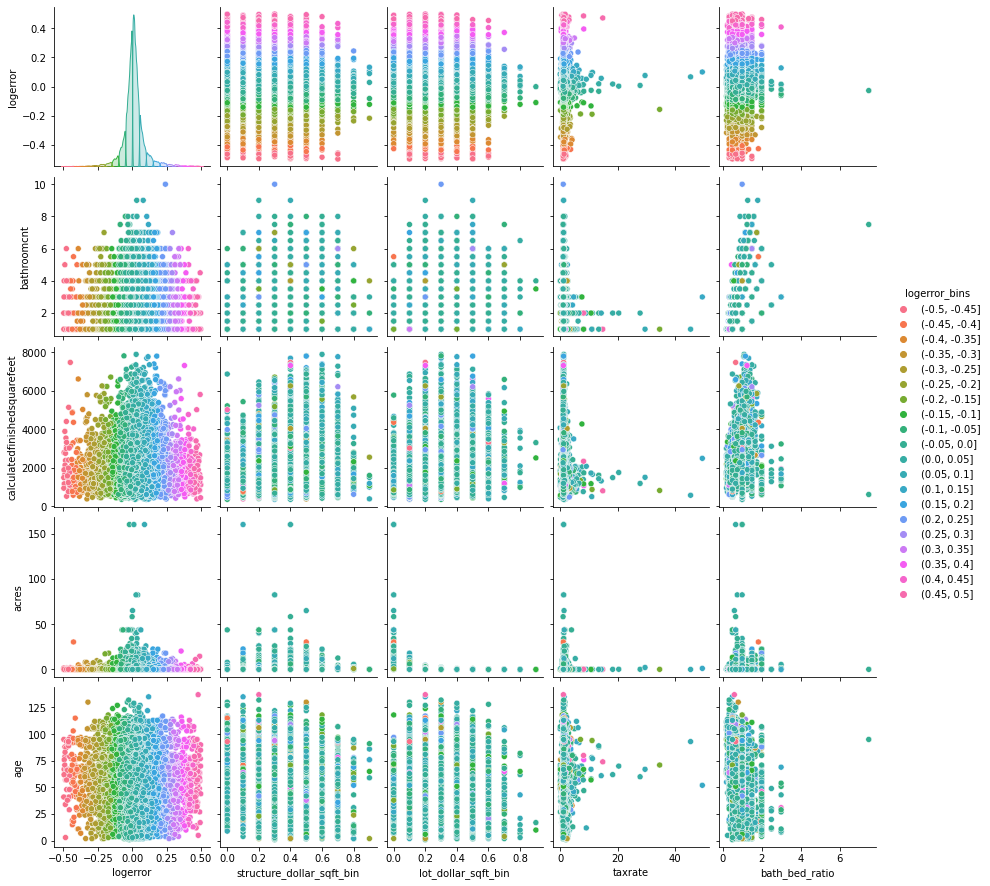

In [18]:
#Create pairplot
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'acres', 'age'])



### The above shows that yes, most logerror is the turquoise or -.1 through .1, but we can also see that the other errors showing up clearly in age, calculated finished sq ft, bathroom count, tax rate, and bed/bath ratio.
****

In [8]:
#create a fresh df that contains the variable we want to use.
df_1 = wrangle.final_df(df)

### Now I will visualize the basic distributions of variables.  While this doesn't give me much insight, it might help me see the distribution shape, what variables may be of interest to continue to explore.

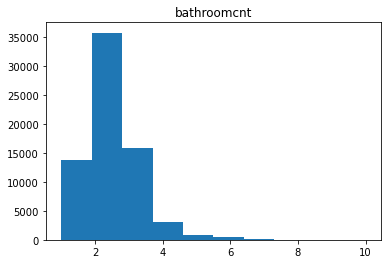

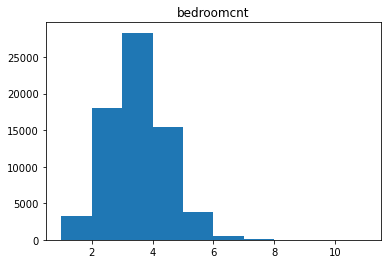

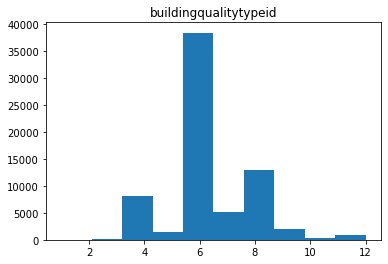

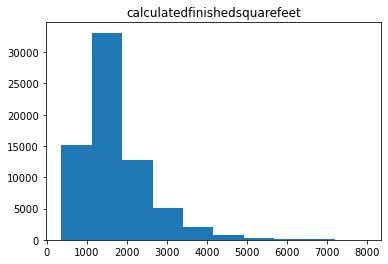

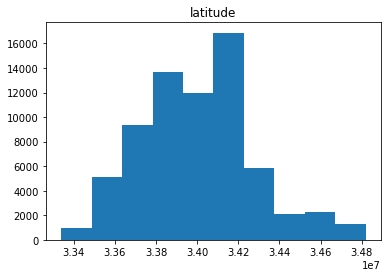

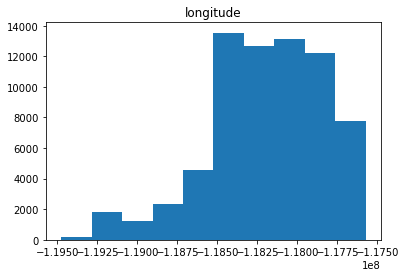

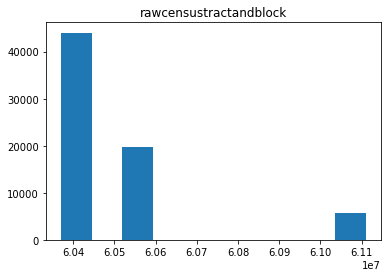

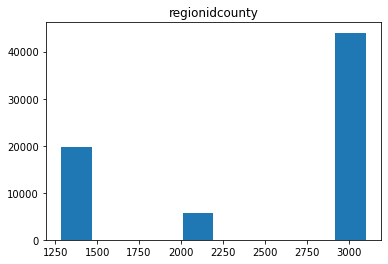

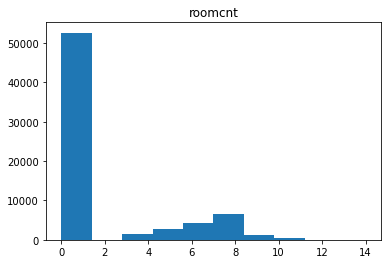

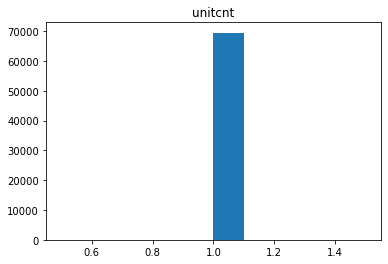

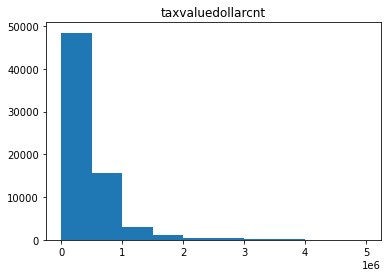

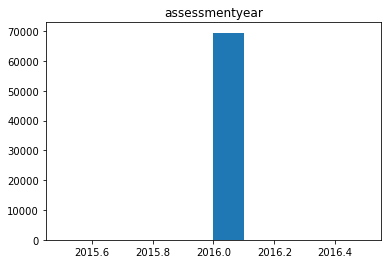

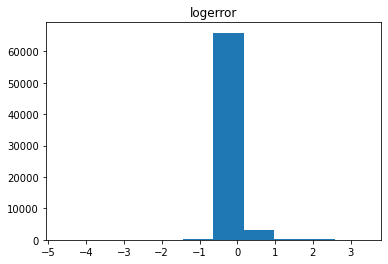

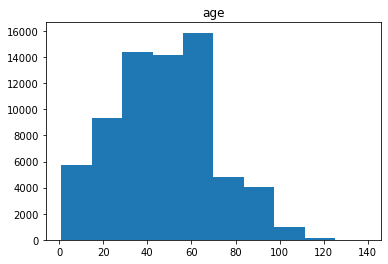

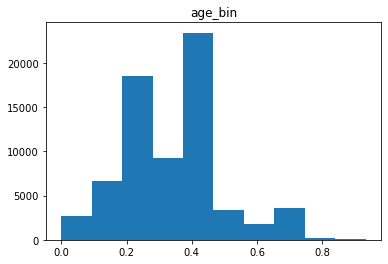

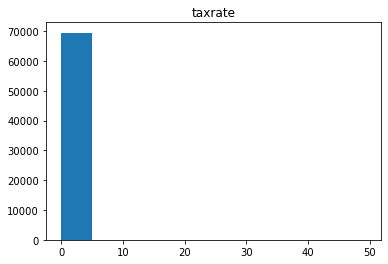

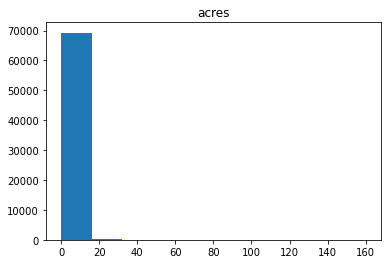

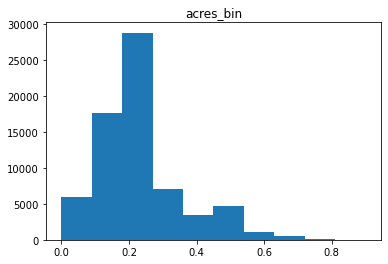

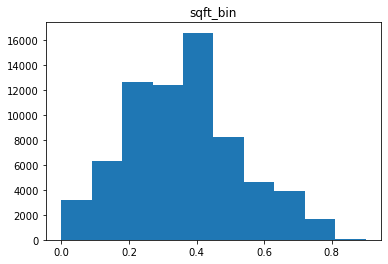

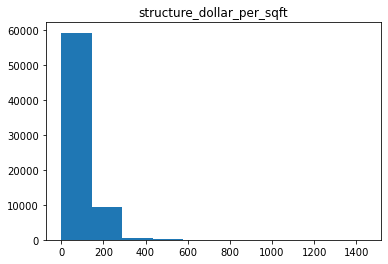

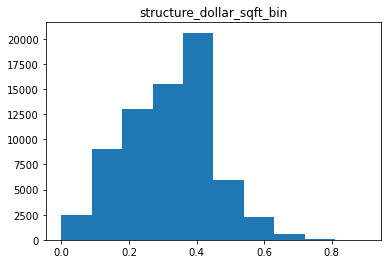

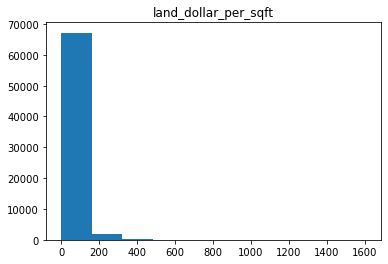

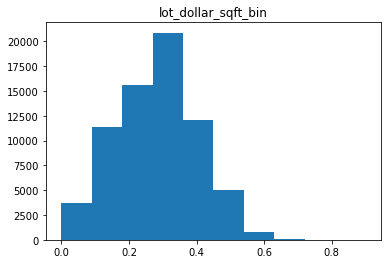

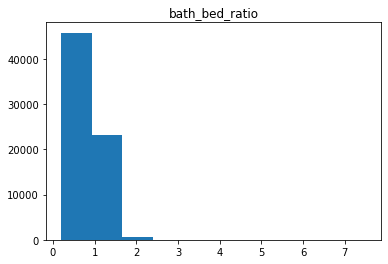

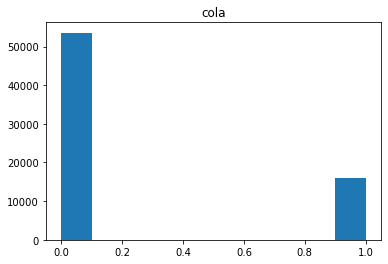

In [9]:
for col in df_1.columns:
    plt.hist(df_1[col])
    plt.title(col)
    plt.show()

### Takeaway: The features Age, Bath_Bed, Acres and Sqft_bins have similar shapes (somewhat).

****
****
****
## Explore through Clustering:
### Now, I will create clusters using area the property is located in and it's size.  This may give me some insight to continue using these variables, or to move on to something different.
### Variables used: latitude, longitude and square feet.

In [10]:
#create a variable to hold the x and y of train, validate and test dataframes.
partitions = wrangle.split(df_1, target_var='logerror')

In [11]:
# the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'taxrate']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])

In [12]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'sqft_bin']
cluster_name = 'area_cluster'
k_range = range(2,20)

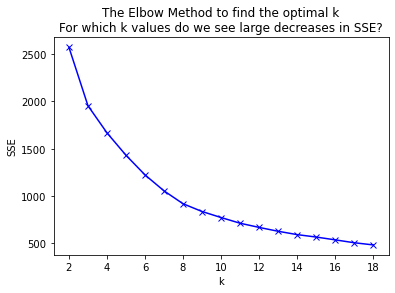

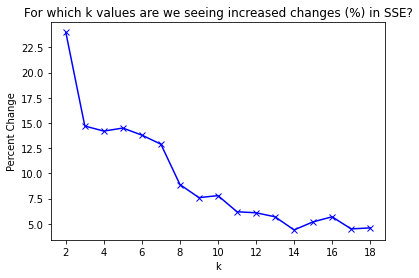

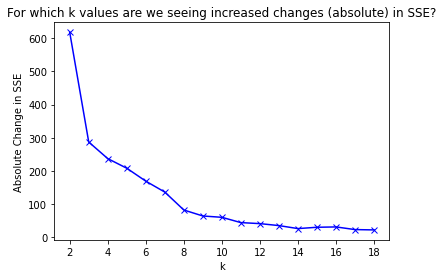

,k,sse,delta,pct_delta
0,2,2573.025993,618.0,24.0
1,3,1954.732048,287.0,14.7
2,4,1667.717001,237.0,14.2
3,5,1430.421208,208.0,14.5
4,6,1222.780694,169.0,13.8
5,7,1053.894507,136.0,12.9
6,8,917.532382,82.0,8.9
7,9,835.506851,64.0,7.6
8,10,771.773358,60.0,7.8
9,11,711.530640,44.0,6.2


In [13]:
model.find_k(X[0], cluster_vars, k_range)

### Based on the Elbow method chart, and the K list, it appears that between 5-6 clusters may be useful. I'll start with 5. 

In [14]:
k = 5
kmeans = model.create_clusters(X[0], k, cluster_vars)
centroid_df = model.get_centroids(kmeans, cluster_vars, cluster_name)


In [15]:
#assign clusters
def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len(X)):
        clusters = pd.DataFrame(kmeans.predict(X[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        X[i] = pd.concat([X[i], clusters_centroids], axis=1)
    return X

X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [16]:
#creating a df to show clusters
pd.DataFrame(X[0].groupby(['area_cluster', 'centroid_scaled_latitude', 'centroid_scaled_longitude', 
                           'centroid_sqft_bin'])['area_cluster'].count())

,,,,area_cluster
area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_sqft_bin,
0,0.320507,0.798850,0.200932,9455
1,0.603681,0.594972,0.494955,8626
2,0.293564,0.830761,0.501858,9308
3,0.540666,0.593839,0.190600,8530
4,0.607324,0.249769,0.401725,3013


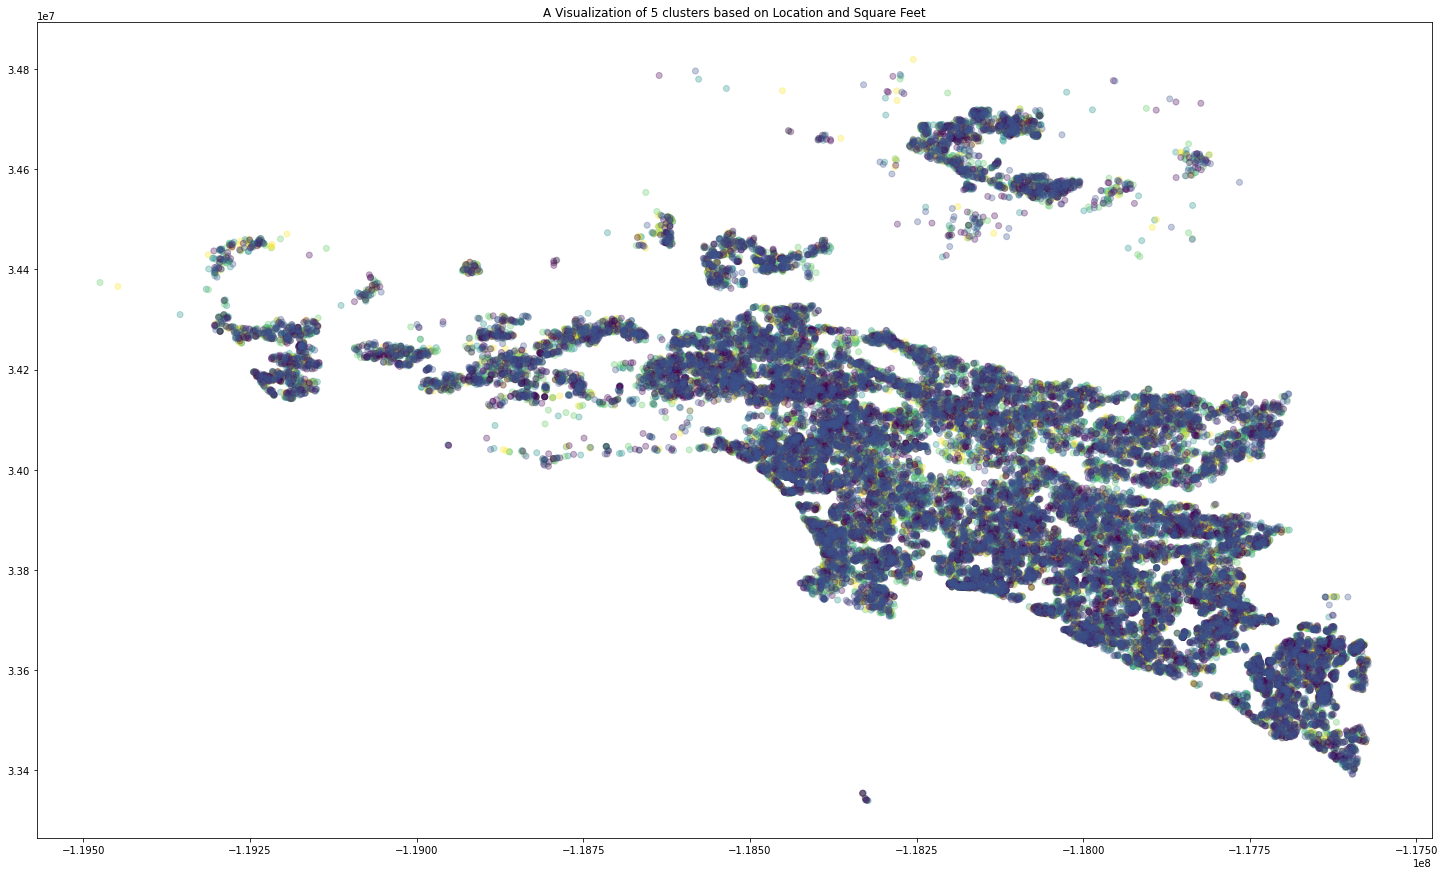

In [64]:
#Create a Visualization of Clusters
plt.figure(figsize=(25,15))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=X[0].latitude, x=X[0].longitude, c=X[0].area_cluster, alpha=.3)
plt.title(f'A Visualization of 5 clusters based on Location and Square Feet')
plt.show()

### Takeaway from that cluster combination:  This grouping is not useful in any way at this point.  I will try visualizing the clusters via a pair plot.
### Perhaps looking at individual features with clusters, will give me some further insight.
****
### I will use Bathroom Count, Square Feet, Acres, and Bath/Bed Ratio

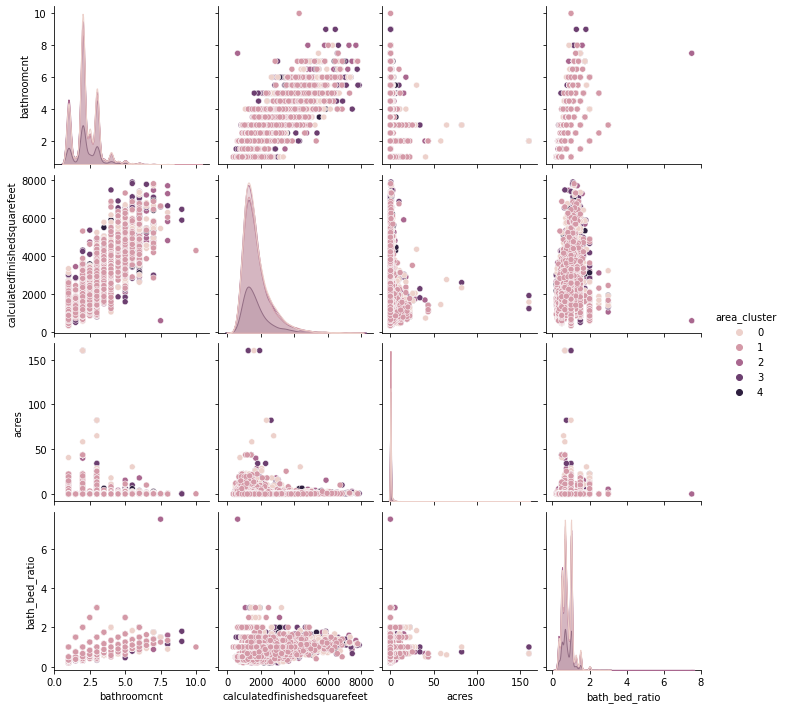

In [23]:
#create a df to hold the features
plt_df = X[0][['bathroomcnt', 'calculatedfinishedsquarefeet', 
                    'acres', 'bath_bed_ratio', 'area_cluster']]

sns.pairplot(data=plt_df, hue='area_cluster')

### Takeaway: While this still doesn't give me much insight, I can see that clusters 1 and 2 contain the overwhelming majority of properties.  At this point, I am going to move foward with exploring.

In [65]:
#sanity check for train
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,...,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,logerror_bins
75698,2.5,3.0,6.0,2368.0,6059.0,33680878.0,-118026177.0,2040.0,6.059099e+07,25218.0,...,0.046832,0.0,0.5,117.843328,0.4,111.156373,0.5,0.833333,0,"(0.0, 0.05]"
46252,2.0,2.0,8.0,1194.0,6037.0,34143200.0,-118126000.0,13303.0,6.037464e+07,47019.0,...,0.305395,0.3,0.2,103.121441,0.4,6.256408,0.2,1.000000,0,"(-0.1, -0.05]"
2425,2.0,2.0,6.0,1178.0,6111.0,34267400.0,-119244000.0,1306.0,6.111003e+07,34543.0,...,0.029982,0.0,0.2,82.684211,0.3,74.580398,0.4,1.000000,0,"(-0.05, 0.0]"
62560,2.5,3.0,6.0,1800.0,6059.0,33691124.0,-118001431.0,4000.0,6.059099e+07,25218.0,...,0.091827,0.0,0.4,133.951667,0.4,76.366250,0.4,0.833333,0,"(0.0, 0.05]"
68164,1.0,1.0,6.0,1033.0,6111.0,34284500.0,-119300000.0,7313.0,6.111002e+07,34543.0,...,0.167883,0.2,0.2,165.509197,0.5,1.590182,0.1,1.000000,0,"(0.1, 0.15]"


****
****
****
## Explore using Statistical Hypothesis Testing.
### For all tests, we will set a confidence ratio of 95%. Alpha is set at 0.05%.
****
### #1.
### Our null hypothesis: There is no linear correlation between logerror and Calculatedfinishedsquarefeet
### Our alternative hypothesis: There is a linear correlation between logerror and Calculatedfinishedsquarefeet

In [66]:
#create the stats test function:
def correlation_exploration(train, x_string, y_string):
    '''
    This function takes in a df, a string for an x-axis variable in the df, 
    and a string for a y-axis variable in the df and displays a scatter plot, the r-
    squared value, and the p-value. It explores the correlation between input the x 
    and y variables.
    '''
    r, p = stats.pearsonr(train[x_string], train[y_string])
    df.plot.scatter(x_string, y_string)
    plt.title(f"{x_string}'s Relationship with {y_string}")
    print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
    print(f'r = {round(r, 2)}')
    plt.show()

The p-value is: 1.2779426839868207e-17. There is 0.0% chance that we see these results by chance.
r = 0.04


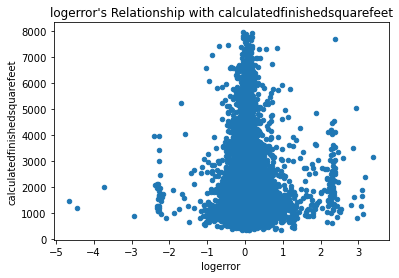

In [21]:
correlation_exploration(train, 'logerror', 'calculatedfinishedsquarefeet')

### We reject the null hypothesis for the above.
****
### #2.

### Using the same confidence ratio of 95%. Alpha is set at 0.05%.
### Our null hypothesis: There is no linear correlation between logerror and latitude.
### Our alternative hypothesis: There is a linear correlation between logerror and latitude.

The p-value is: 0.001518750391405347. There is 0.002% chance that we see these results by chance.
r = -0.02


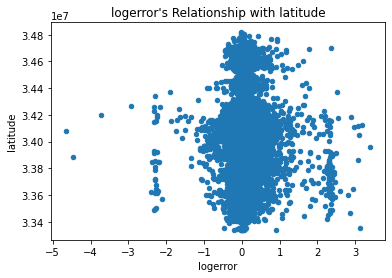

In [22]:
correlation_exploration(train, 'logerror', 'latitude')

### We reject the null hypothesis for the above.
****
### #3.
### Using the same confidence ratio of 95%. Alpha is set at 0.05%.
### Our null hypothesis: There is no linear correlation between logerror and longitude.
### Our alternative hypothesis: There is a linear correlation between logerror and longitude.

The p-value is: 0.0009006376561893873. There is 0.001% chance that we see these results by chance.
r = 0.02


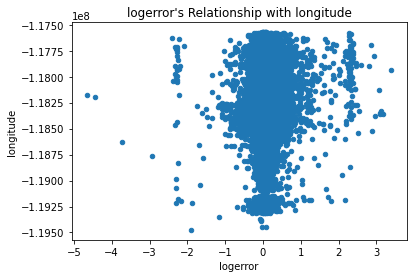

In [23]:
correlation_exploration(train, 'logerror', 'longitude')

### We reject the null hypothesis for the above.
****
### #4.
### Using the same confidence ratio of 95%. Alpha is set at 0.05%.
### Our null hypothesis: There is no linear correlation between logerror and bath_bed_ratio.
### Our alternative hypothesis: There is a linear correlation between logerror and bath_bed_ratio.

The p-value is: 0.8431862576845132. There is 0.843% chance that we see these results by chance.
r = -0.0


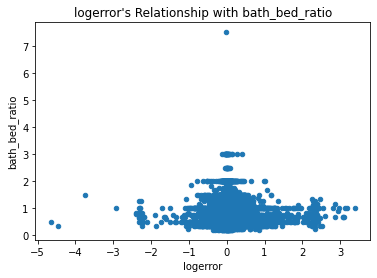

In [24]:
correlation_exploration(train, 'logerror', 'bath_bed_ratio')

### We fail to reject the null hypothesis for the above. We have confidence that there is a linear correlation between logerror and Bath/Bed Ratio.
****
### #5.
### Using the same confidence ratio of 95%. Alpha is set at 0.05%.
### Our null hypothesis: There is no linear correlation between logerror and acres.
### Our alternative hypothesis: There is a linear correlation between logerror and acres.

The p-value is: 0.0008523997921687042. There is 0.001% chance that we see these results by chance.
r = 0.02


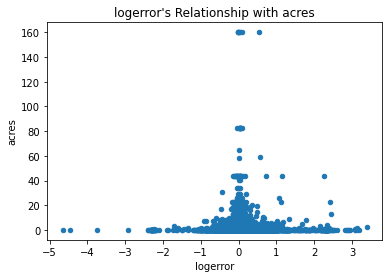

In [25]:
correlation_exploration(train, 'logerror', 'acres')

### We reject the null hypothesis for the above.
****
## Takeaways from above, so far the features that seem to have a relationship with logerror is the bath/bed ratio. 
****
### I will move on to modeling using all features, then for comparison: the bath_bed_ratio, along with other features that showed visual correlation to bath_bed_ratio (from the first pair plot we created) and my original hunch that longitude may be contributing. Comparing models will help me know if I'm on the right track for finding drivers of logerror.

****
****
****
## Modeling:
### Establish a baseline using the mean of logerror.  
### Create multiple linear regression models to see if they perform better than baseline.

****
### Below we see that the RMSE to beat is .16. 

In [27]:
#Create baseline using Mean and Median.
y_train = partitions[4]
y_validate = partitions[5]

# 1. Predict logerror_pred_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16
RMSE using Median
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16


In [71]:
#Establish baseline using mean
baseline_mean = logerror_pred_mean
print ("The Baseline using the logerror mean is", round(baseline_mean, 6))

The Baseline using the logerror mean is 0.016403


In [72]:
#Establish baseline using median
baseline_median = logerror_pred_median
print ("The Baseline using the logerror median is", round(baseline_median, 6))

The Baseline using the logerror median is 0.006635


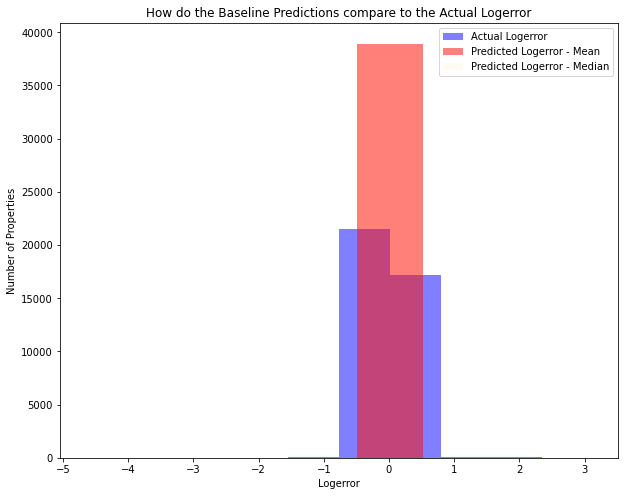

In [74]:
#Visualize the Baseline with Actual
plt.figure(figsize=(10,8))
# plot to visualize actual vs predicted. 

plt.hist(y_train.logerror, color='blue', alpha=.5, label="Actual Logerror")
plt.hist(y_train.logerror_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Logerror - Mean")
plt.hist(y_train.logerror_pred_median, bins=1, color='orange', alpha=.05, rwidth=100, label="Predicted Logerror - Median")
plt.xlabel("Logerror")
plt.ylabel("Number of Properties")
plt.title("How do the Baseline Predictions compare to the Actual Logerror")
plt.legend()
plt.show()

### As you can see from the above chart, the baseline is much different than the actual.  Hopefully with modeling we can improve the baseline.

****
### Listed below are the results of the OLS Model, Lasso + Lars Model,  and Tweedie Regression Model
### First we will use all features in the model.

In [75]:
#Create an OLS Model using all features
X_validate = partitions[1]
y_validate = partitions[4]

# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16995741450924784 
Validation/Out-of-Sample:  0.16995741450924784


In [32]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17041290010855104 
Validation/Out-of-Sample:  0.17041290010855104


In [33]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  0.17015932842534562 
Validation/Out-of-Sample:  0.17015932842534562


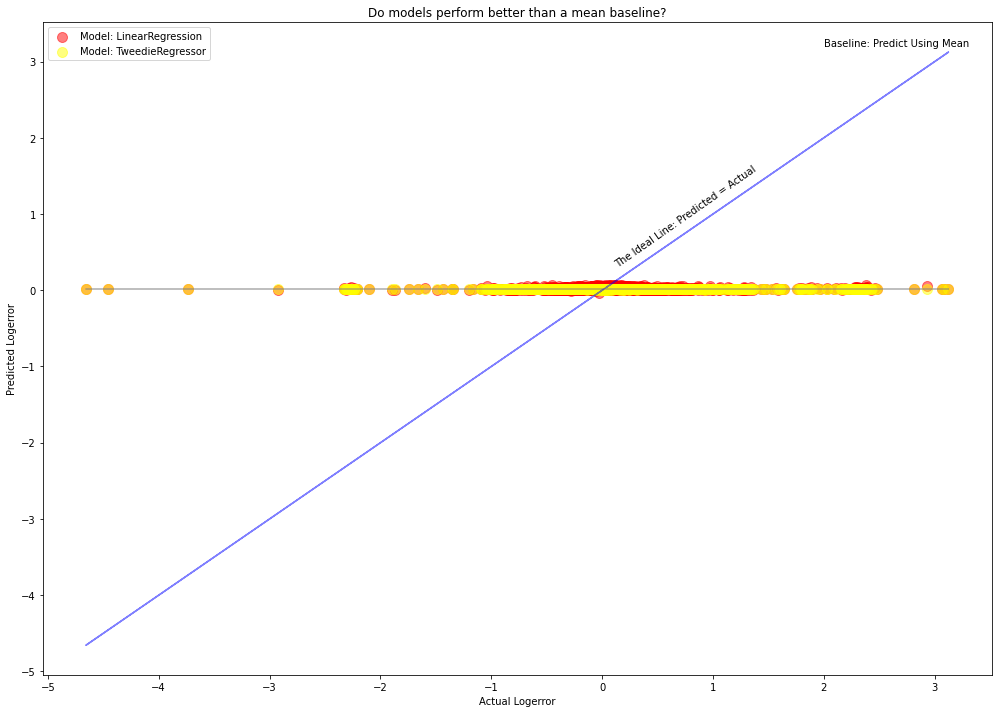

In [63]:
# y_validate.head()
plt.figure(figsize=(17,12))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (2, 3.2))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.1, 0.3), rotation=35)

plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#plt.scatter(y_validate.G3, y_validate.G3_pred_lm2, 
#            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Logerror")
plt.ylabel("Predicted Logerror")
plt.title("Do models perform better than a mean baseline?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### These models perform barely better than the baseline. 
### Now we'll model using only features that visually correllated to bath_bed_ratio
****

### Let's set a X and y train with just the features for this model.

In [83]:
#X_trainC = X_train[['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'bath_bed_ratio']]
X_trainC = X_train[['calculatedfinishedsquarefeet','longitude', 'age', 'bath_bed_ratio']]
y_trainC = y_train.logerror

#X_validateC = X_validate[['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'bath_bed_ratio']]
X_validateC = X_validate[['calculatedfinishedsquarefeet', 'longitude', 'age', 'bath_bed_ratio']]
y_validateC = y_validate.logerror

### Now it's time to see if these models do any better than our previous models (including Baseline).
****
****

In [84]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_trainC, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_trainC)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validateC)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.17022353925798428 
Validation/Out-of-Sample:  0.17022353925798428


In [85]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_trainC, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_trainC)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validateC)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.17041290010855104 
Validation/Out-of-Sample:  0.17041290010855104


In [86]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_trainC, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_trainC)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validateC)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  0.17041289988304284 
Validation/Out-of-Sample:  0.17041289988304284


****
### Baseline: .16
****

****
### Using all features: 
### Tweedie Regressor: .170159
### Lasso + Lars: .170413
### OLS Linear Regression: .169957
****

****
### Using only the selected features, the models above:  
### Tweedie Regressor: .170413
### Lasso + Lars: .170413
### OLS Linear Regression: .170224
****

In [76]:
print ("The Tweedie Regressor model using selected features only, does",(round((.170413 - .170159), 6)* 100),'% better than using all features, and', (round((.170402 - .16), 5)* 100),'% better than baseline.')

The Tweedie Regressor model using selected features only, does 0.0243 % better than using all features, and 1.04 % better than baseline.


In [88]:
print ("The OLS Linear Regression model using selected features only, does",(round((.170224 - .169957), 5)* 100),'% better than using all features, and', (round((.170224 - .16), 5)* 100),'% better than baseline.')

The OLS Linear Regression model using selected features only, does 0.027 % better than using all features, and 1.022 % better than baseline.


## This suggests that the selected features (Bath_Bed_Ratio, Total Square Feet, Age, and Longitude) may drive logerror more than all features.  
****
## To further understand what is driving logerror, my future iterations would include different groupings of features to get the best overall performance.